In [3]:
import pysam
import Bio
from Bio import SeqIO
from Bio.SeqUtils import GC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd
import seaborn as sns

In [4]:
def samfile_stats(samfile):
    samfile = pysam.AlignmentFile(samfile, "r")
    iter = samfile.fetch()
    total = 0
    non_neg_pos = 0
    ref_regions = []
    no_hits = []
    pos = []
    for x in iter:
        total += 1
        if x.reference_start > -1:
            ref_regions.append(x.reference_id)
            pos.append(x.reference_start)
            non_neg_pos += 1
        else:
            no_hits.append(x.reference_id)
    
    print("ALIGNMENT RATE: ", non_neg_pos / total)
    print("REGIONS: ", set(ref_regions))
    print("NO HIT REGIONS: ", set(no_hits))
    
    return pd.DataFrame({"REGIONS":  ref_regions, "POSITION": pos})

# sam file read in as Dataframe

In [5]:
# Alignment results from seed length of 15 (BEST)
df = samfile_stats("bwa_align_seed_15.sam")

ALIGNMENT RATE:  0.8129087183881273
REGIONS:  {0, 1, 2}
NO HIT REGIONS:  {-1}


# sam file parsed in command line to extract region IDs with number of reads

In [37]:
read_hits = []
with open("regions_hits_bwa", "r") as ref_info:
    for line in ref_info:
        info = line.split(" ")
        read_hits.append((info[0], int(info[1])-1))

In [38]:
read_hits[0:10]

[('NZ_CP009617.1', 904151),
 ('NZ_CP009617.1', 904065),
 ('NZ_CP009617.1', 1257417),
 ('NZ_CP009617.1', 1256912),
 ('NZ_CP009617.1', 827685),
 ('NZ_CP009617.1', 827668),
 ('NZ_CP009617.1', 129644),
 ('NZ_CP009617.1', 129476),
 ('NZ_CP009618.1', 531766),
 ('NZ_CP009618.1', 531367)]

# Sliding window of size 100 and compute GC content of each window

In [9]:
L = 100
ref = []
windows = []
gc = []
chunks = []
with open("ref1.fna", "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        chunks += [(record.id, record.seq[i:i+L], (i,i+L-1)) for i in range(0, len(record.seq), L)]

In [10]:
gc = [[chunks[i][0], chunks[i][2], GC(chunks[i][1])] for i in range(len(chunks))]

In [11]:
gc[0:10]

[['NZ_CP009617.1', (0, 99), 39.0],
 ['NZ_CP009617.1', (100, 199), 35.0],
 ['NZ_CP009617.1', (200, 299), 30.0],
 ['NZ_CP009617.1', (300, 399), 36.0],
 ['NZ_CP009617.1', (400, 499), 43.0],
 ['NZ_CP009617.1', (500, 599), 51.0],
 ['NZ_CP009617.1', (600, 699), 48.0],
 ['NZ_CP009617.1', (700, 799), 47.0],
 ['NZ_CP009617.1', (800, 899), 47.0],
 ['NZ_CP009617.1', (900, 999), 53.0]]

# Get read counts for each window

In [12]:
def get_hit_counts(sam_hits):
    hit_count_dict = {}
    for (hid, pos) in sam_hits:
        if not (hid, pos) in hit_count_dict.keys():
            hit_count_dict[(hid, pos)] = 1
        else:
            hit_count_dict[(hid, pos)] += 1
    return hit_count_dict

In [13]:
def get_full_results(sliding_windows, hit_count_dict):
    results = []
    for window in sliding_windows:
        count = 0
        for i in range(window[1][0], window[1][1]+1):
            try:
                count += hit_count_dict[(window[0], i)]
            except Exception:
                None
        results.append(window + [count])
    return results

In [14]:
hits = get_hit_counts(read_hits)

In [15]:
results = get_full_results(gc, hits)

In [16]:
results[0:10]

[['NZ_CP009617.1', (0, 99), 39.0, 252],
 ['NZ_CP009617.1', (100, 199), 35.0, 122],
 ['NZ_CP009617.1', (200, 299), 30.0, 125],
 ['NZ_CP009617.1', (300, 399), 36.0, 98],
 ['NZ_CP009617.1', (400, 499), 43.0, 89],
 ['NZ_CP009617.1', (500, 599), 51.0, 94],
 ['NZ_CP009617.1', (600, 699), 48.0, 94],
 ['NZ_CP009617.1', (700, 799), 47.0, 77],
 ['NZ_CP009617.1', (800, 899), 47.0, 59],
 ['NZ_CP009617.1', (900, 999), 53.0, 67]]

# Put results into pandas dataframe

In [25]:
data = pd.DataFrame(results, columns=['REFID', 'window', 'GC', 'hits'])
data.head()

,REFID,window,GC,hits
0,NZ_CP009617.1,"(0, 99)",39.0,252
1,NZ_CP009617.1,"(100, 199)",35.0,122
2,NZ_CP009617.1,"(200, 299)",30.0,125
3,NZ_CP009617.1,"(300, 399)",36.0,98
4,NZ_CP009617.1,"(400, 499)",43.0,89


In [43]:
# Write out metrics to tsv file
data.to_csv("sliding_window_metrics_bwa.tsv", index=False)

,REFID,window,GC,hits
0,NZ_CP009617.1,"(0, 99)",39.0,252
1,NZ_CP009617.1,"(100, 199)",35.0,122
2,NZ_CP009617.1,"(200, 299)",30.0,125
3,NZ_CP009617.1,"(300, 399)",36.0,98
4,NZ_CP009617.1,"(400, 499)",43.0,89


# Split window counts into high and low GC regions

In [18]:
low_gc = data[data.GC <= 40]
high_gc = data[data.GC >= 55]

In [23]:
low_gc.describe()

,GC,hits
count,11178.000000,11178.000000
mean,36.314751,59.538200
std,3.793620,54.602975
min,12.000000,0.000000
25%,35.000000,0.000000
50%,37.000000,75.000000
75%,39.000000,91.000000
max,40.000000,2189.000000


In [24]:
high_gc.describe()

,GC,hits
count,3200.000000,3200.000000
mean,57.047187,47.928438
std,2.368114,44.523347
min,55.000000,0.000000
25%,55.000000,0.000000
50%,56.000000,61.000000
75%,58.000000,74.000000
max,74.000000,805.000000


In [26]:
set(data.REFID)

{'NZ_CP009617.1', 'NZ_CP009618.1', 'NZ_CP009619.1', 'NZ_CP009620.1'}

# Remove regions with minimal hits

In [27]:
data_filtered = data[data.REFID != 'NZ_CP009620.1']
data_filtered = data_filtered[data_filtered.REFID != 'NZ_CP009619.1']

In [28]:
data_filtered.describe()

,GC,hits
count,53378.000000,53378.000000
mean,45.525778,71.940088
std,5.780689,38.581102
min,12.000000,0.000000
25%,42.000000,63.000000
50%,46.000000,74.000000
75%,49.000000,85.000000
max,74.000000,3346.000000


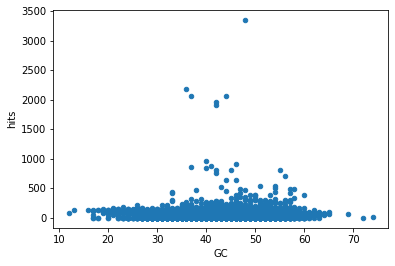

In [29]:
data_filtered.plot.scatter('GC', 'hits')

# Split filtered data and perform t-test

In [30]:
high_gc = data_filtered[data_filtered.GC >= 55]
low_gc = data_filtered[data_filtered.GC <= 40]

In [31]:
from scipy.stats import ttest_ind

In [32]:
ttest_ind(list(high_gc.hits), list(low_gc.hits), equal_var=False)

Ttest_indResult(statistic=-3.8923447516195853, pvalue=0.00010071410450685265)

### The p-value from t-test is 0.001007